## 爬取汇率信息

In [1]:
import requests
payload = { #开发者工具中看到的
'projectBean.startDate':'2017-02-01',
'projectBean.endDate':'2017-05-01',
'queryYN':'true'
}
res = requests.post('http://www.safe.gov.cn/AppStructured/view/project_RMBQuery.action', data = payload)
res

<Response [200]>

In [17]:
#res.text

## 剖析汇率信息

In [2]:
from bs4 import BeautifulSoup
import pandas
soup = BeautifulSoup(res.text, 'html.parser')
type(soup.select('#InfoTable')[0])
type(soup.select('#InfoTable')[0].prettify('utf-8'))
#pandas.read_html(soup.select('#InfoTable')[0])
dfs = pandas.read_html(soup.select('#InfoTable')[0].prettify('utf-8'), header=0)#pandas读取表格
#     header=0 表示header用的是第0行数据
#prettify('utf-8')： tag转为str
#len(dfs)
#dfs[0]
df_rates = dfs[0]

In [3]:
df_rates.head()

,日期,美元,欧元,日元,港元,英镑,林吉特,卢布,兰特,韩元,...,丹麦克朗,瑞典克朗,挪威克朗,里拉,比索,澳元,加元,新西兰元,新加坡元,瑞士法郎
0,2017-04-28,689.31,749.45,6.2023,88.584,889.61,62.822,826.93,193.24,16387.0,...,99.20,128.04,124.23,51.631,275.98,515.34,506.28,474.81,493.90,693.82
1,2017-04-27,688.96,751.87,6.1977,88.546,885.74,62.829,827.94,192.26,16383.0,...,98.94,127.03,124.47,51.810,278.13,515.42,506.37,475.50,494.06,694.12
2,2017-04-26,688.45,752.50,6.1964,88.477,883.71,63.213,814.87,189.81,16358.0,...,98.86,127.36,124.41,51.996,274.05,519.05,507.26,478.34,493.98,693.05
3,2017-04-25,688.33,747.63,6.2746,88.478,880.27,63.662,810.73,189.17,16452.0,...,99.43,128.67,124.27,51.934,273.42,520.55,508.40,482.56,494.36,691.44
4,2017-04-24,686.73,746.24,6.2433,88.316,880.67,63.827,818.72,189.23,16457.0,...,99.68,128.77,124.19,52.596,271.20,519.10,509.39,483.42,493.15,691.59


## 数据转换

In [93]:
#pandas.melt(df_rates, col_level=0, id_vars=['日期'])

In [4]:
df_rates = pandas.melt(df_rates, col_level=0, id_vars=['日期'])#转换为3栏数据

In [96]:
#df_rates.head()

In [5]:
df_rates.columns = ['date', 'currency', 'exchange']#改名称

In [6]:
df_rates.head()

,date,currency,exchange
0,2017-04-28,美元,689.31
1,2017-04-27,美元,688.96
2,2017-04-26,美元,688.45
3,2017-04-25,美元,688.33
4,2017-04-24,美元,686.73


## 将数据储存到数据库中

In [7]:
import sqlite3 as lite
with lite.connect('currency.sqlite') as db:  
    df_rates.to_sql('currency_data', con=db, if_exists='replace', index = None)

## 产生多天日期

In [8]:
from datetime import datetime, timedelta
current_time = datetime.now()
for i in range(1,300,30):
    #print(i)
    start_date = (current_time - timedelta(days = i + 30)).strftime('%Y-%m-%d')
    end_date   = (current_time - timedelta(days = i + 1)).strftime('%Y-%m-%d')
    print(start_date, end_date)

2017-05-11 2017-06-09
2017-04-11 2017-05-10
2017-03-12 2017-04-10
2017-02-10 2017-03-11
2017-01-11 2017-02-09
2016-12-12 2017-01-10
2016-11-12 2016-12-11
2016-10-13 2016-11-11
2016-09-13 2016-10-12
2016-08-14 2016-09-12


## 建立取得汇率函数

In [9]:
def getCurrency(start, end):
    payload = {
    'projectBean.startDate':start,
    'projectBean.endDate':end,
    'queryYN':'true'
    }
    res = requests.post('http://www.safe.gov.cn/AppStructured/view/project_RMBQuery.action', data = payload)
    soup = BeautifulSoup(res.text, 'html.parser')
    dfs = pandas.read_html(soup.select('#InfoTable')[0].prettify('utf-8'), header=0)
    df_rates = dfs[0]
    
    df_rates = pandas.melt(df_rates, col_level=0, id_vars=['日期'])
    df_rates.columns = ['date', 'currency', 'exchange']
    
    with lite.connect('currency.sqlite') as db:
        df_rates.to_sql('currency_data', con=db, if_exists='append', index = None)

## 抓取多天汇率数据

In [10]:
from datetime import datetime, timedelta
current_time = datetime.now()
for i in range(1,300,30):
    start_date = (current_time - timedelta(days = i + 30)).strftime('%Y-%m-%d')
    end_date   = (current_time - timedelta(days = i + 1)).strftime('%Y-%m-%d')
    print(start_date, end_date)
    getCurrency(start_date, end_date)

2017-05-11 2017-06-09
2017-04-11 2017-05-10
2017-03-12 2017-04-10
2017-02-10 2017-03-11
2017-01-11 2017-02-09
2016-12-12 2017-01-10
2016-11-12 2016-12-11
2016-10-13 2016-11-11
2016-09-13 2016-10-12
2016-08-14 2016-09-12


## 取得美元数据

In [11]:
with lite.connect('currency.sqlite') as db:
    df = pandas.read_sql("SELECT * FROM currency_data WHERE currency = '美元'", con=db)

In [12]:
df.count()

date        256
currency    256
exchange    256
dtype: int64

In [33]:
df.head()

,date,currency,exchange
0,2017-04-28,美元,689.31
1,2017-04-27,美元,688.96
2,2017-04-26,美元,688.45
3,2017-04-25,美元,688.33
4,2017-04-24,美元,686.73


In [36]:
df['date'] = pandas.to_datetime(df['date'], format= '%Y-%m-%d')

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256 entries, 0 to 255
Data columns (total 3 columns):
date        256 non-null object
currency    256 non-null object
exchange    256 non-null float64
dtypes: float64(1), object(2)
memory usage: 6.1+ KB


In [14]:
df.index = df.date

## 绘制美元汇率线图

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


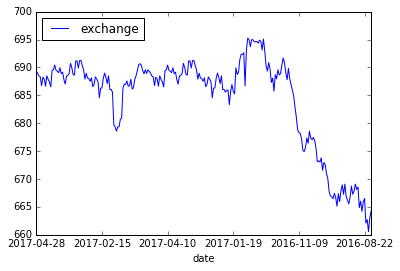

In [15]:
% pylab inline
df.plot(kind = 'line')

In [16]:
df['mvg30'] = df['exchange'].rolling(window = 30).mean()

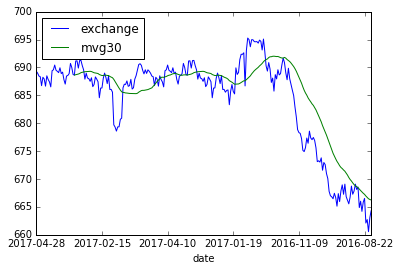

In [17]:
df[['exchange', 'mvg30']].plot(kind = 'line')

## 取得美元、英镑数据

In [18]:
with lite.connect('currency.sqlite') as db:
    df = pandas.read_sql("SELECT * FROM currency_data WHERE currency IN ('美元', '英镑') ", con=db)

In [19]:
df.currency.unique()

array(['美元', '英镑'], dtype=object)

In [20]:
df['date'] = pandas.to_datetime(df['date'], format= '%Y-%m-%d')

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 512 entries, 0 to 511
Data columns (total 3 columns):
date        512 non-null datetime64[ns]
currency    512 non-null object
exchange    512 non-null float64
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 12.1+ KB


In [22]:
df.head()

,date,currency,exchange
0,2017-04-28,美元,689.31
1,2017-04-27,美元,688.96
2,2017-04-26,美元,688.45
3,2017-04-25,美元,688.33
4,2017-04-24,美元,686.73


## 建立Pivot Table

In [23]:
df2 = df.pivot_table(index= 'date', columns= 'currency')

In [24]:
df2.head()

exchange        
currency         美元      英镑
date                       
2016-08-15   664.30  857.45
2016-08-16   663.05  854.37
2016-08-17   660.56  861.28
2016-08-18   662.73  864.57
2016-08-19   662.11  871.24

## 绘制美元、英镑汇率线图

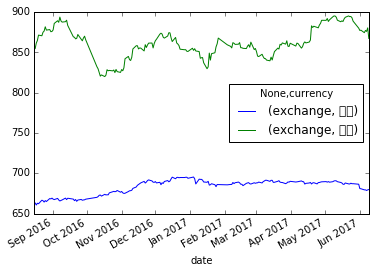

In [25]:
df2.plot(kind= 'line', rot= 30)

In [27]:
10 * 1024 *1024 / 30 / 24 / 60

242.7259259259259